## Problem Set #2
MACS 30200, Dr. Evans and Dr. Soltoff

Shuting Chen 

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import math 
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import LeaveOneOut
from sklearn.neighbors import KernelDensity
%matplotlib notebook

/Users/shuting/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/shuting/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/shuting/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  Dep

### Q1. 2D kernel density estimator

#### Part (a). 

In [2]:
bq_data = np.loadtxt('BQmat_orig.txt', delimiter=',')
print('Sum of all probabilities', bq_data.sum())

Sum of all probabilities 1.0


<IPython.core.display.Javascript object>


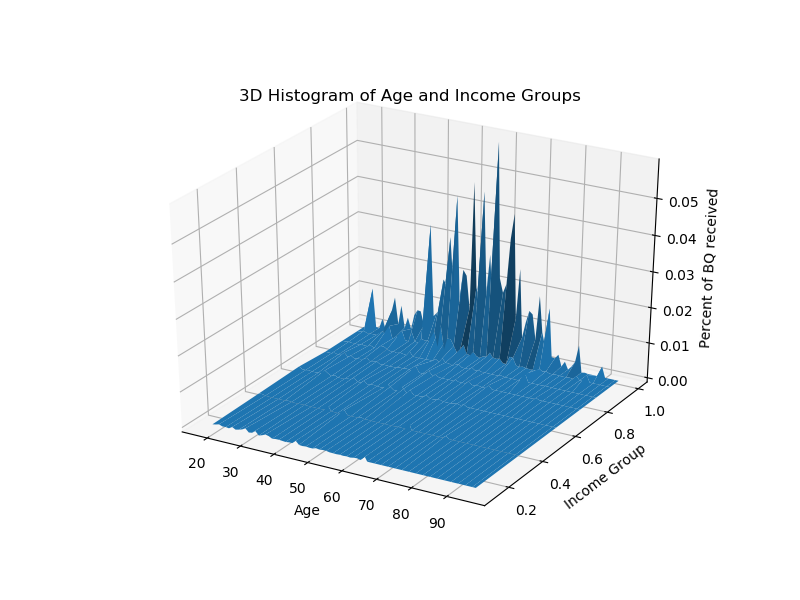

In [3]:
# Make 3D surface plot of rough bequests distribution matrix
age_vec = np.arange(18, 96)
lambdas = np.array([0.25, 0.25, 0.20, 0.10, 0.10, 0.09, 0.01])
lambdas_mdpts = np.array([0.125, 0.375, 0.60, 0.75, 0.85,
                          0.94, 0.995])
income_mat, age_mat = np.meshgrid(lambdas_mdpts, age_vec)

fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')
ax.plot_surface(age_mat, income_mat, bq_data)
ax.set_title('3D Histogram of Age and Income Groups')
ax.set_xlabel('Age')
ax.set_ylabel('Income Group')
ax.set_zlabel('Percent of BQ received')
plt.show()

#### Part (b).

In [4]:
prop_mat_inc = np.sum(bq_data, axis=0)
prop_mat_age = np.sum(bq_data, axis=1)
lrg_samp = 70000
age_probs = np.random.multinomial(lrg_samp, prop_mat_age)
income_probs = np.random.multinomial(lrg_samp, prop_mat_inc)
age_freq = np.array([])
inc_freq = np.array([])

# creating a distribution of age values
for age, num_s in zip(age_vec, age_probs):
    vec_age_s = np.ones(num_s)
    vec_age_s *= age
    age_freq = np.append(age_freq, vec_age_s)

# creating a distribution of ability type values
for abil, num_j in zip(lambdas_mdpts, income_probs):
    vec_abil_j = np.ones(num_j)
    vec_abil_j *= abil
    inc_freq = np.append(inc_freq, vec_abil_j)

# estimate bandwidth with leave one out cross validation
bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut(len(bq_data)))
grid.fit(bq_data);

data = np.vstack((age_freq, inc_freq))
density = gaussian_kde(data, bw_method=grid.best_params_["bandwidth"])

coords = np.vstack([item.ravel() for item in [age_mat, income_mat]])
BQkde = density(coords).reshape(age_mat.shape)
BQkde_scaled = BQkde /np.sum(BQkde)

<IPython.core.display.Javascript object>


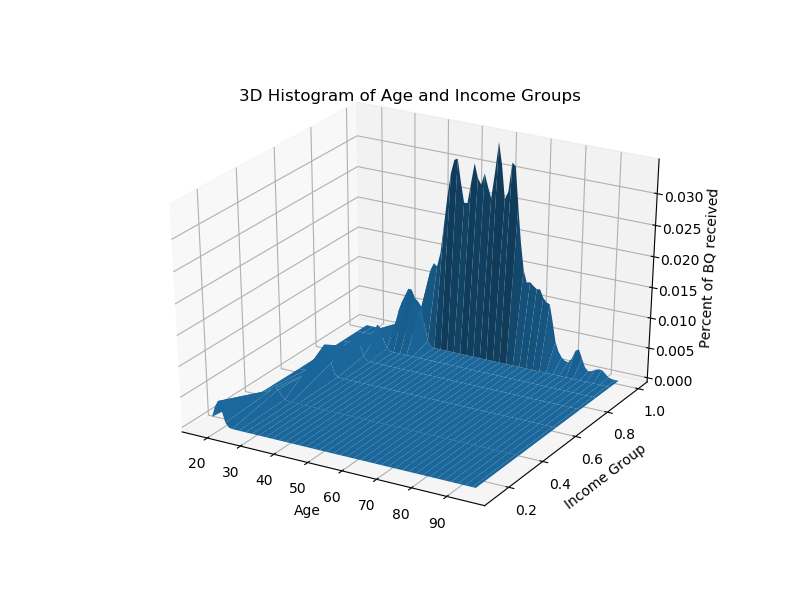

Text(0.5,0,'Percent of BQ received')

In [5]:
fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')
ax.plot_surface(age_mat, income_mat, BQkde_scaled)
ax.set_title('3D Histogram of Age and Income Groups')
ax.set_xlabel('Age')
ax.set_ylabel('Income Group')
ax.set_zlabel('Percent of BQ received')

In [6]:
grid.best_params_["bandwidth"]

0.10000000000000001

The best bandwidth is estimated by leave one out cross validation. As shown above, the best value of bandwidth should be around 0.1. 

The estimated density for bequest recipients who are
age 61 in the 6th lifetime income category:

In [7]:
BQkde_scaled[42, 5]

1.7492576098009789e-06

### Q2. Interaction terms 

In [8]:
# Regression results
biden = pd.read_csv("biden.csv")
biden ['const'] = 1
biden ['interaction'] = biden ['age'] * biden['educ']
reg1 = sm.OLS(endog=biden['biden'], exog=biden[['const', 'age', 
        'educ', 'interaction']], missing='drop')
results1 = reg1.fit()
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:                  biden   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     10.13
Date:                Mon, 30 Apr 2018   Prob (F-statistic):           1.29e-06
Time:                        00:59:00   Log-Likelihood:                -8333.3
No. Observations:                1826   AIC:                         1.667e+04
Df Residuals:                    1822   BIC:                         1.670e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          37.5491      9.491      3.956      

The estimated linear regression model is: 
$$\hat{Y} = 37.549\,+\,0.667\,X_1\,+\,1.712\,X_2\,-\,0.048\,X_1\,X_2$$

#### (a). Evaluate the marginal effect of age, conditional on education   

In [9]:
gb1 = biden.groupby('educ')
values_educ = gb1.groups.keys()
b_hat_age = results1.params['age']
b_hat_inter = results1.params['interaction']
cov_matrix = results1.cov_params()
var_age = cov_matrix.iloc[1][1]
var_inter = cov_matrix.iloc[3][3]
cov_age_inter = cov_matrix.iloc[1][3]

<IPython.core.display.Javascript object>


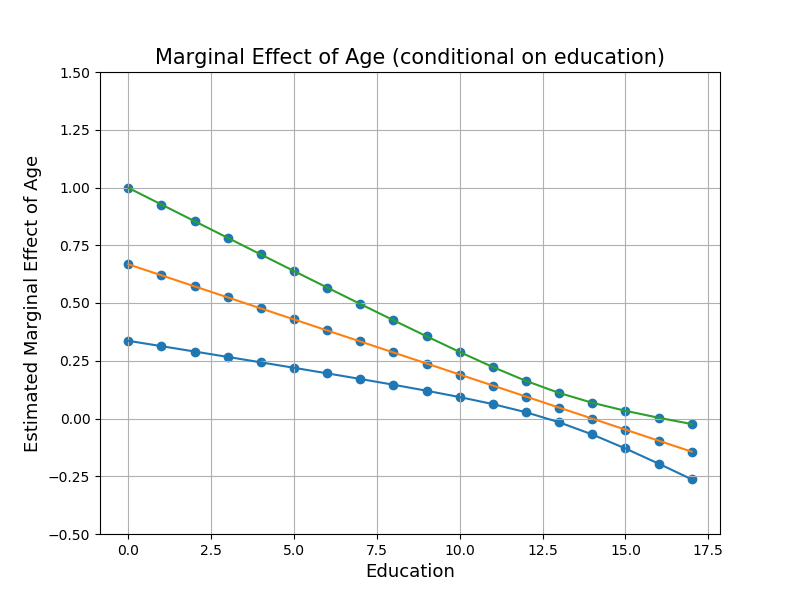

In [10]:
exp_marg_eff0 = []
exp_marg_eff = []
value_list = []

for i in values_educ:
    marg_eff = b_hat_age + b_hat_inter * i 
    se = math.sqrt(var_age + i**2 * var_inter + 2 * i * cov_age_inter)
    ymin_95 = marg_eff - 1.96 * se
    ymax_95 = marg_eff + 1.96 * se
    exp_marg_eff.append([ymin_95, marg_eff, ymax_95])
    exp_marg_eff0.append(marg_eff)
    value_list.append([int(i)]*3)

plt.figure(figsize=(8,6))
plt.scatter(value_list, exp_marg_eff)
plt.plot(value_list, exp_marg_eff)

plt.title('Marginal Effect of Age (conditional on education)', fontsize=15)
plt.xlabel('Education', fontsize=13)
plt.ylabel('Estimated Marginal Effect of Age', fontsize=13)
plt.ylim(-0.5, 1.5)
plt.grid(True, which='both')
plt.show()
    

The marginal effect of age on Joe Biden thermometer rating,conditional on education is $\beta_1 + \beta_3 X_2$, and the estimated marginal effect is $0.667 -\,0.048 X_2$. Based on the regression results, we can conclude that coefficients of age and interaction term are both statistically significant at 1% significance level. By plugging in all possible values of education one at a time, we can get the plot (second the line) shown in the graph above. The area between the first line and the third line is 95% confidence interval for estimated marginal effect of age conditional on each value of education. From the plots, we can observe that as education level increases the estimated marginal effect of age decreases, changing from $0.70$ to $-0.14$. Besides, the 95% confidence interval firstly shrinks and then becomes a bit spread out.  

#### (b). Evaluate the marginal effect of education, conditional on age  

In [11]:
gb2 = biden.groupby('age')
values_age = gb2.groups.keys()
b_hat_educ = results1.params['educ']
var_educ = cov_matrix.iloc[2][2]
cov_educ_inter = cov_matrix.iloc[2][3]

<IPython.core.display.Javascript object>


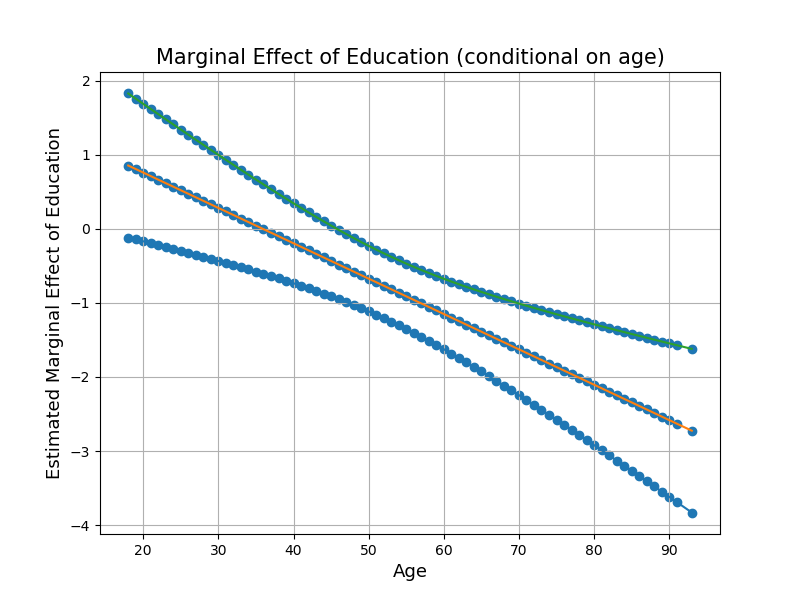

In [12]:
exp_marg_eff1 = []
exp_marg_eff2 = []
value_list1 = []

for i in values_age:
    marg_eff = b_hat_educ + b_hat_inter * i 
    se = math.sqrt(var_educ + i**2 * var_inter + 2 * i * cov_educ_inter)
    ymin_95 = marg_eff - 1.96 * se
    ymax_95 = marg_eff + 1.96 * se
    exp_marg_eff2.append([ymin_95, marg_eff, ymax_95])
    exp_marg_eff1.append(marg_eff)
    value_list1.append([int(i)]*3)

plt.figure(figsize=(8,6))
plt.scatter(value_list1, exp_marg_eff2)
plt.plot(value_list1, exp_marg_eff2)

plt.title('Marginal Effect of Education (conditional on age)', fontsize=15)
plt.xlabel('Age', fontsize=13)
plt.ylabel('Estimated Marginal Effect of Education', fontsize=13)
plt.grid(True, which='both')
plt.show()

The marginal effect of education on Joe Biden thermometer rating,conditional on age is $\beta_2 + \beta_3 X_1$, and the estimated marginal effect is $1.712 -\,0.048 X_1$. Based on the regression results, we can conclude that coefficients of education and interaction term are both statistically significant at 5% significance level. By plugging in all possible values of age one at a time, we can get the plot (second the line) shown in the graph above. The area between the first line and the third line is 95% confidence interval for estimated marginal effect of education conditional on each value of age. From the plots, we can observe that as age increases the estimated marginal effect of education decreases, changing from $1.0$ to $-2.9$. Besides, the 95% confidence interval firstly shrinks and then becomes more spread out again when age is over 55.  